In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider
provider = SaverProvider()

# How to use

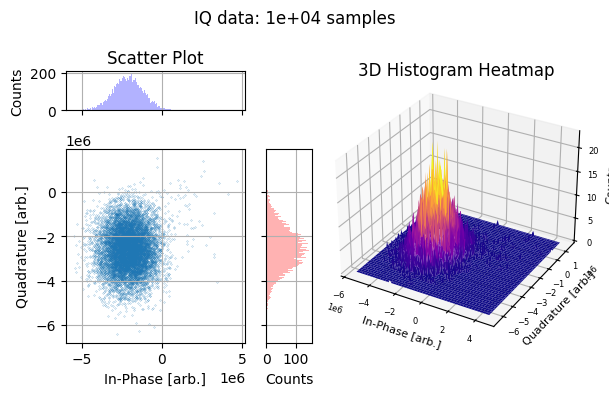

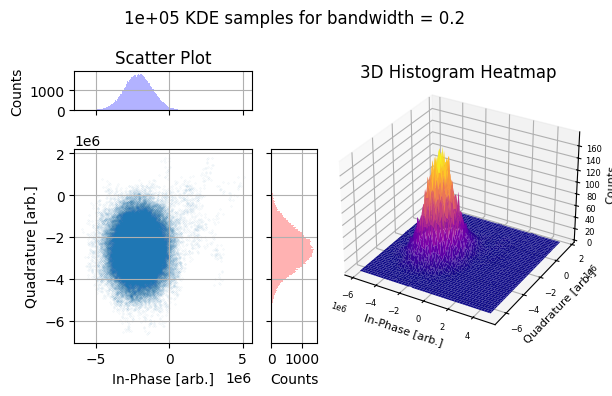

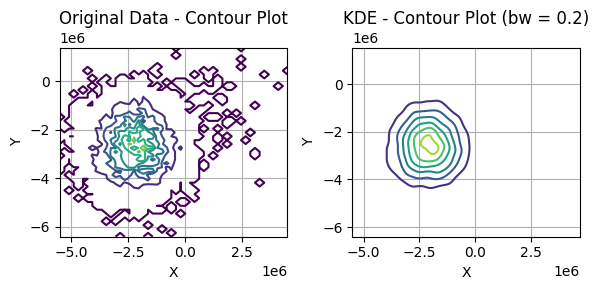

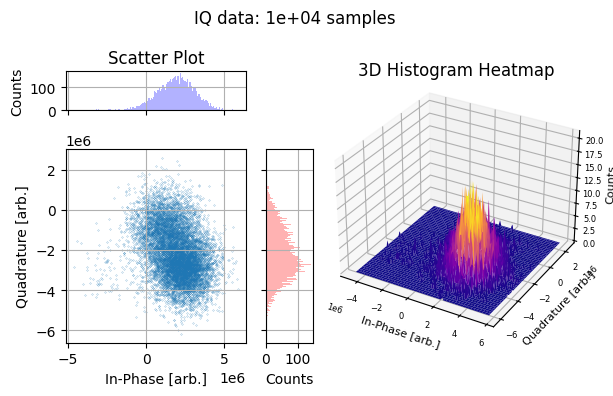

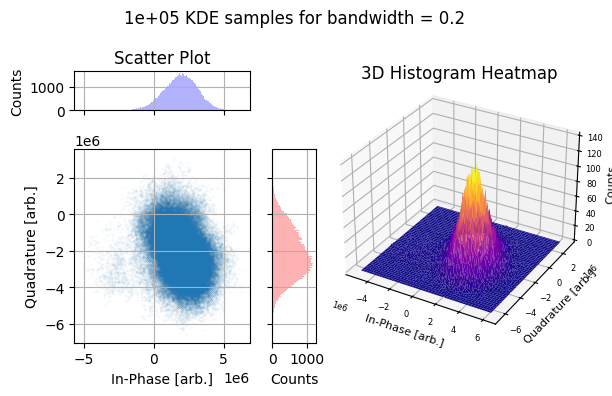

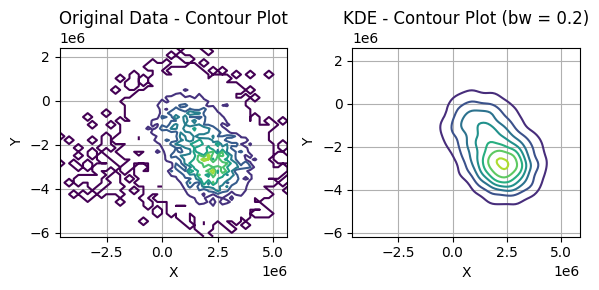

In [6]:
from soft_info import get_KDEs

device = 'ibm_sherbrooke'

KDEs, scalar = get_KDEs(provider, device, qubit=1, plot=True)

# Function building

In [8]:
import warnings
from Scratch import metadata_loader


def load_calibration_memory(provider, device, qubit, _take_newest=True):
    md = metadata_loader(extract=True).dropna(subset=["num_qubits"])

    mask = (
        (md["backend_name"] == device) &
        (md["job_status"] == "JobStatus.DONE") &
        (md["optimization_level"] == 0) &
        (
            (md["sampled_state"] == md["num_qubits"].apply(lambda x: '1' * int(x))) |
            (md["sampled_state"] == md["num_qubits"].apply(lambda x: '0' * int(x)))
        )
    )
    md_filtered = md.loc[mask]
    if _take_newest:
        md_filtered = md_filtered[:2] # Only take newest two jobs

    memories = {}
    for job_id, sampled_state in zip(md_filtered["job_id"], md_filtered["sampled_state"]):
        mmr_name = f"mmr_{sampled_state[0]}"
        job = provider.retrieve_job(job_id)
        memory = job.result().get_memory()

        if qubit < memory.shape[1]:  # Check if qubit index is valid
            memories[mmr_name] = memory[:, int(qubit)]

    if len(memories) != 2:
        warnings.warn(
            f"Loaded {len(memories)} memories with keys {list(memories.keys())}, expected 2.")

    return memories

memories = load_calibration_memory(provider, "ibm_sherbrooke", 126)

print(memories)
print("Shape of memories:", memories["mmr_0"].shape)

{'mmr_0': array([-10684527.+14992431.j, -10904223.+17017118.j,
       -12095339.+15631168.j, ..., -11430347.+14711652.j,
       -20667214.+16056637.j,  -7548490.+15038275.j]), 'mmr_1': array([-12667017.+20442666.j,  -9988574.+14170527.j,
       -11102100.+14023566.j, ..., -11066968.+14490758.j,
       -11581066.+15659437.j, -16300549.+18931947.j])}
Shape of memories: (10000,)


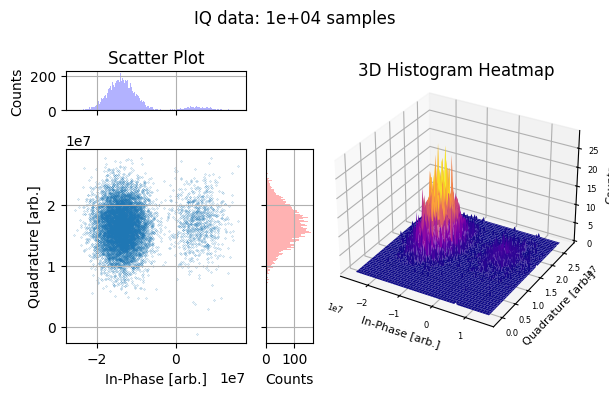

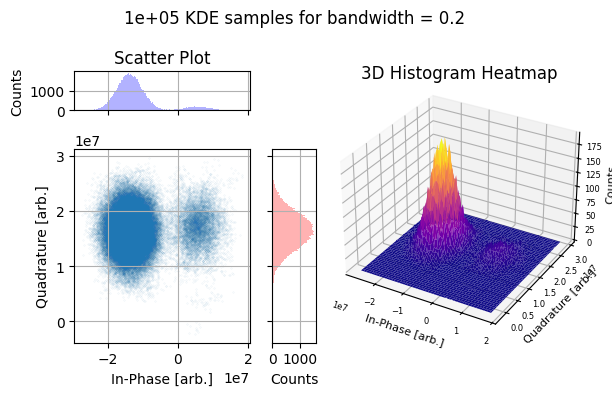

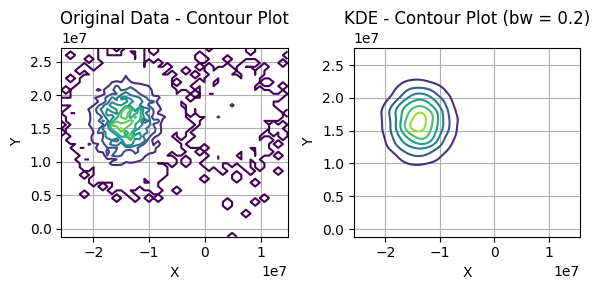

(KernelDensity(bandwidth=0.2), StandardScaler())

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from soft_info import plot_IQ_data


def plot_KDE(data, kde, scaler):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    # Contour plot of original data
    nbins = 50
    hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=nbins)
    axs[0].contour(xedges[:-1], yedges[:-1], hist.T, cmap='viridis')
    axs[0].grid()
    axs[0].set_title('Original Data - Contour Plot')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')

    # Contour plot of KDE
    x_grid = np.linspace(min(data[:, 0]) - 1, max(data[:, 0]) + 1, 100)
    y_grid = np.linspace(min(data[:, 1]) - 1, max(data[:, 1]) + 1, 100)
    xv, yv = np.meshgrid(x_grid, y_grid)
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T

    log_dens = kde.score_samples(scaler.transform(gridpoints))
    dens = np.exp(log_dens).reshape(xv.shape)
    axs[1].contour(x_grid, y_grid, dens, cmap='viridis')
    axs[1].grid()
    axs[1].set_title(f'KDE - Contour Plot (bw = {kde.bandwidth})')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')

    plt.tight_layout()
    plt.show()


def fit_KDE(IQ_data, bandwidth=0.1, plot=False, num_samples=1e5, scaler=None):
    data = IQ_data.flatten()
    combined_data = np.column_stack((data.real, data.imag))

    if not scaler:
        scaler = StandardScaler()

    normalized_data = scaler.fit_transform(combined_data)

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(normalized_data)

    if plot:
        plot_IQ_data(IQ_data, figsize=(6,4), title=f"IQ data: {len(data):.0e} samples")
        kde_samples = kde.sample(int(num_samples))
        kde_samples = scaler.inverse_transform(kde_samples)
        kde_complex_samples = kde_samples[:, 0] + 1j * kde_samples[:, 1]

        plot_IQ_data(kde_complex_samples, figsize=(6,4), title=f"{num_samples:.0e} KDE samples for bandwidth = {bandwidth}")
        plot_KDE(combined_data, kde, scaler)

    return kde, scaler


fit_KDE(memories["mmr_1"], bandwidth=0.2, plot=True)

In [12]:
def fit_KDE_CV():
    return

In [15]:
from typing import Union

def get_KDEs(provider, device, qubit, bandwidths : Union[float, list] = 0.2, plot : Union[bool, list] = False):
    bw0, bw1 = (bandwidths, bandwidths) if not isinstance(bandwidths, list) else bandwidths
    plot0, plot1 = (plot, plot) if not isinstance(plot, list) else plot    
    
    memories = load_calibration_memory(provider, device, qubit)  

    kde_0, scaler_0 = fit_KDE(memories["mmr_0"], bandwidth=bw0, plot=plot0)
    kde_1, scaler_1 = fit_KDE(memories["mmr_1"], bandwidth=bw1, plot=plot1)

    return [kde_0, kde_1], [scaler_0, scaler_1]